In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from collections import Counter
import json

# Data Preprocessing

In this analysis, I focused on the voters' data (the one who votes, either upvotes or downvotes) in '44_million_votes.txt'

The following are the preprocessing code that changes epoch time to datetime. It is time-consuming so I have stored processed file

votes = pd.read_table('44_million_votes.txt')
info = pd.read_table('submission_info.txt')

votes_dated = votes[np.isnan(votes['CREATED_TIME']) == False]
votes_dated['Time'] = pd.to_datetime(votes_dated['CREATED_TIME'],unit='s')
votes_timed = votes_dated.drop(columns=['CREATED_TIME'])
votes_timed.to_csv('votes_timed.csv')

'44_million_votes.txt' contains the submission id, the subreddit at which the thread locates, the time of vote, the username of the voter and time of voting. 

In [2]:
votes_timed = pd.read_csv('votes_timed.csv')

upvotes = votes_timed[votes_timed['VOTE'] == 'upvote']
downvotes = votes_timed[votes_timed['VOTE'] == 'downvote']

In [3]:
votes_timed.head()

,Unnamed: 0,SUBMISSION_ID,SUBREDDIT,USERNAME,VOTE,Time
0,1043840,t3_1g6rx,r/programming,jdh30,downvote,2007-04-08 04:01:09
1,1043841,t3_2ponf,r/programming,JeebusWept,upvote,2007-09-15 02:42:24
2,1043842,t3_62v57,r/politics,rotzak,upvote,2007-12-13 03:02:19
3,1043843,t3_6548m,r/science,z4r4thustr4,downvote,2008-01-10 18:42:07
4,1043844,t3_6549n,r/reddit.com,z4r4thustr4,downvote,2008-01-10 18:50:32


As shown below, 76.8% of the votes are upvotes and 23.2% are downvotes.

total_votes = votes_timed.shape[0]
print('% of upvotes:',upvotes.shape[0]/votes_timed.shape[0]*100, '%')
print('% of downvotes:', downvotes.shape[0]/votes_timed.shape[0]*100, '%')

In this exploratory data analysis, I chose the top 1000 voters (in terms of total votes) and top 1000 subreddits (in terms of votes) as a starting point and formed a 1000x1000 matrix where the (i,j)-th term is the frequency of ith voter votes in jth subreddit.

voter_counter = Counter(votes_timed['USERNAME'])
sub_counter = Counter(votes_timed['SUBREDDIT'])

voter1000 = voter_counter.most_common(1000)
sub1000 = sub_counter.most_common(1000)

with open('voter1000.json', 'w') as fp:
    json.dump(voter1000, fp)

with open('sub1000.json', 'w') as fp:
    json.dump(sub1000, fp)


voter1000_up_counter = {}
voter1000_down_counter = {}

for i, voter in enumerate(voter1000):
    #if i % 10 == 0:
        #print(i,voter)
    voter1000_up_counter[voter[0]] = Counter(upvotes[upvotes['USERNAME'] == voter[0]]['SUBREDDIT'])
    voter1000_down_counter[voter[0]] = Counter(downvotes[downvotes['USERNAME'] == voter[0]]['SUBREDDIT'])

with open('voter1000_up_counter.json', 'w') as fp:
    json.dump(voter1000_up_counter, fp)

with open('voter1000_down_counter.json', 'w') as fp:
    json.dump(voter1000_down_counter, fp)


In [4]:
with open('voter1000.json') as f:
    voter1000 = json.load(f)

with open('sub1000.json') as f:
    sub1000 = json.load(f)

with open('voter1000_up_counter.json') as f:
    voter1000_up = json.load(f)

with open('voter1000_down_counter.json') as f:
    voter1000_down = json.load(f)

In [5]:
freq = np.zeros((1000,1000))
freq_up = np.zeros((1000,1000))
freq_down = np.zeros((1000,1000))

for i, voter in enumerate(voter1000):
    for j, sub in enumerate(sub1000):
        if sub[0] in voter1000_up[voter[0]]:
            freq[i,j] += voter1000_up[voter[0]][sub[0]]
            freq_up[i,j] += voter1000_up[voter[0]][sub[0]]
        if sub[0] in voter1000_down[voter[0]]:
            freq[i,j] += voter1000_down[voter[0]][sub[0]]
            freq_down[i,j] += voter1000_down[voter[0]][sub[0]]

As shown below, around 17.7% of the entries are nonzero. The resultant matrix is not as sparse as that of authors, but still quite sparse

In [6]:
np.sum(freq!=0)/(1000*1000)

0.176505

In [7]:
freq_score = freq_up - freq_down

# Principle component analysis

In [8]:
normalized_freq = np.zeros((1000,1000))

for i, voter_freq in enumerate(freq_score):
    if sum(voter_freq):
        normalized_freq[i] = voter_freq/sum(abs(voter_freq))

In [9]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
svd.fit(normalized_freq.T)

explained_var_lst = np.cumsum(svd.explained_variance_ratio_/svd.explained_variance_ratio_.sum())

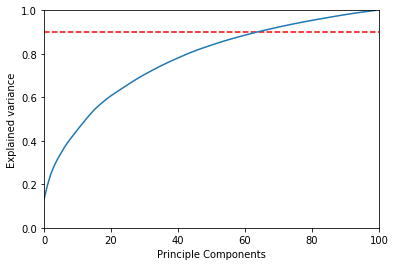

In [10]:
plt.plot(explained_var_lst)
plt.xlabel('Principle Components')
plt.ylabel('Explained variance')
plt.xlim([0,100])
plt.ylim([0,1])
plt.hlines(y=0.9,xmin=0,xmax=500,linestyle='dashed',color='r')
plt.show()

In [11]:
np.where(explained_var_lst>0.9)[0][0]

64

In [12]:
Z = svd.fit_transform(normalized_freq.T)

In [13]:
from wordcloud import WordCloud

Below are the top 20 principle components of the voters. As we can see,  PC 0 would likely upvote threads from 'r/SandersForPresident' and downvote threads from 'r/The_Donald', 'r/conservative' and 'r/conspiracy', which makes sense. 

Voter Principle Component 0
Upvote for 


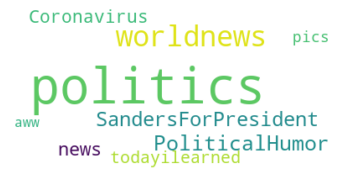

Downvote for 


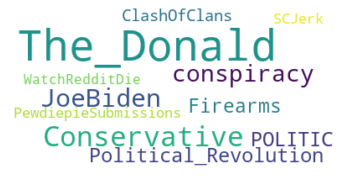

Voter Principle Component 1
Upvote for 


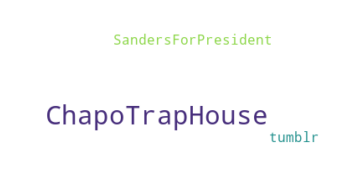

Downvote for 


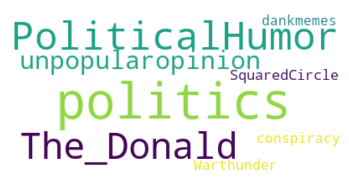

Voter Principle Component 2
Upvote for 


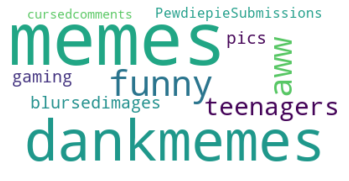

Downvote for 


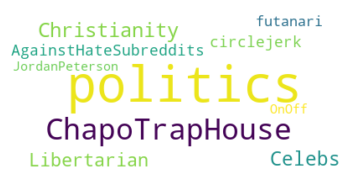

Voter Principle Component 3
Upvote for 


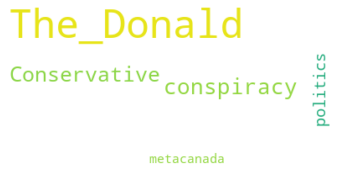

Downvote for 


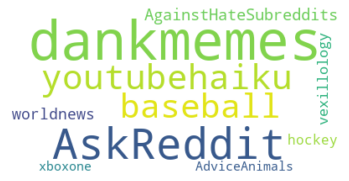

Voter Principle Component 4
Upvote for 


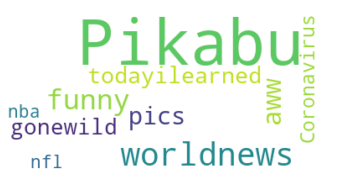

Downvote for 


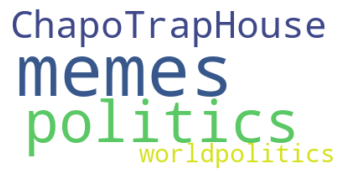

Voter Principle Component 5
Upvote for 


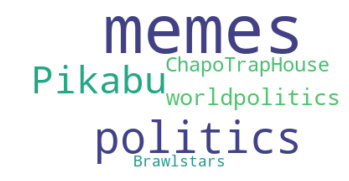

Downvote for 


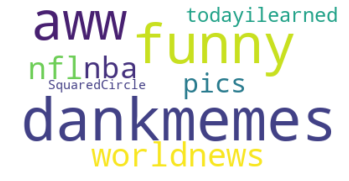

Voter Principle Component 6
Upvote for 


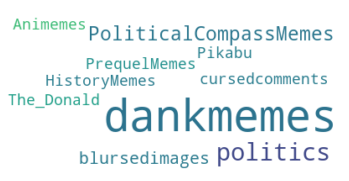

Downvote for 


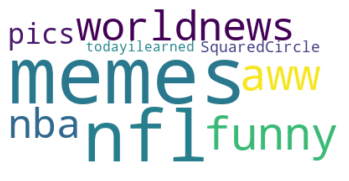

Voter Principle Component 7
Upvote for 


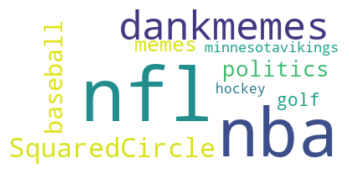

Downvote for 


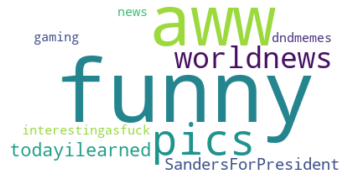

Voter Principle Component 8
Upvote for 


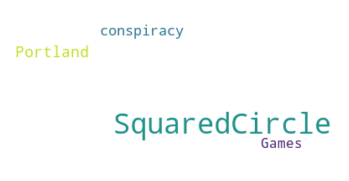

Downvote for 


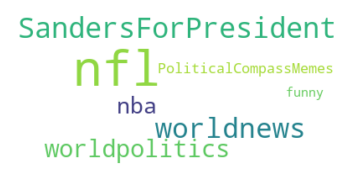

Voter Principle Component 9
Upvote for 


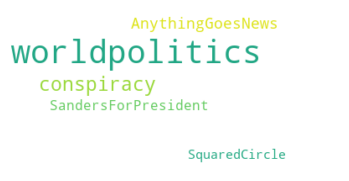

Downvote for 


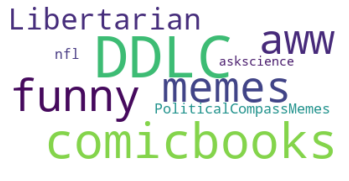

Voter Principle Component 10
Upvote for 


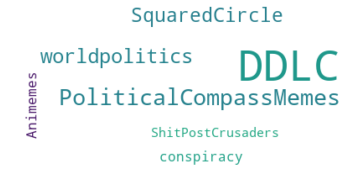

Downvote for 


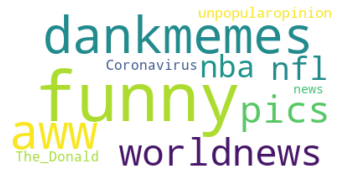

Voter Principle Component 11
Upvote for 


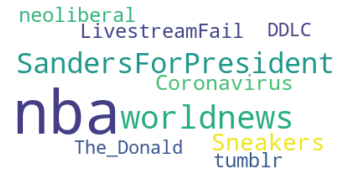

Downvote for 


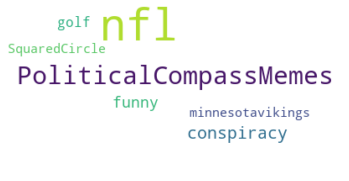

Voter Principle Component 12
Upvote for 


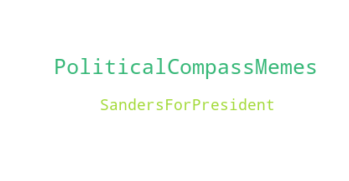

Downvote for 


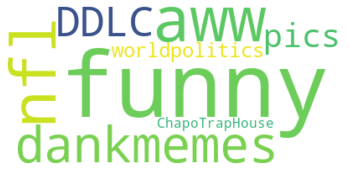

Voter Principle Component 13
Upvote for 


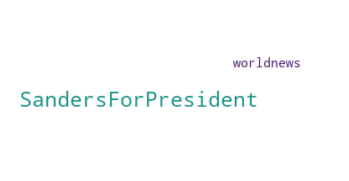

Downvote for 


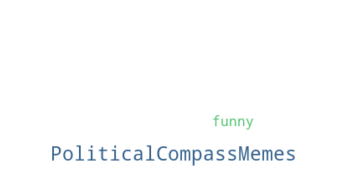

Voter Principle Component 14
Upvote for 


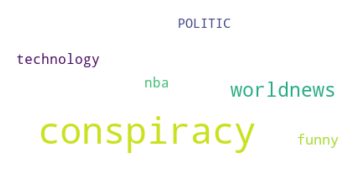

Downvote for 


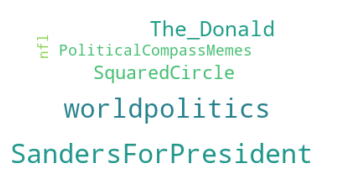

Voter Principle Component 15
Upvote for 


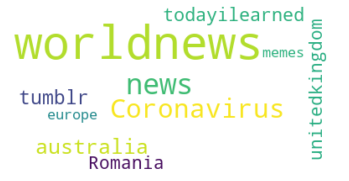

Downvote for 


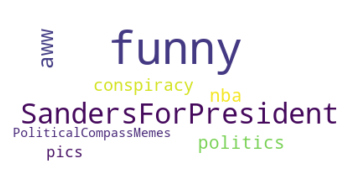

Voter Principle Component 16
Upvote for 


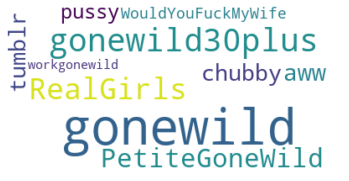

Downvote for 


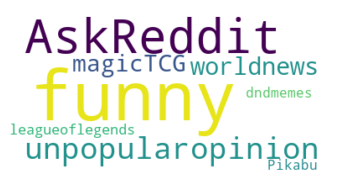

Voter Principle Component 17
Upvote for 


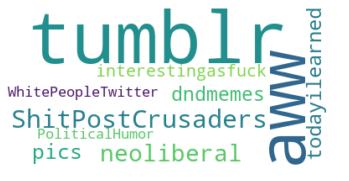

Downvote for 


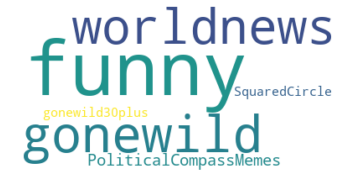

Voter Principle Component 18
Upvote for 


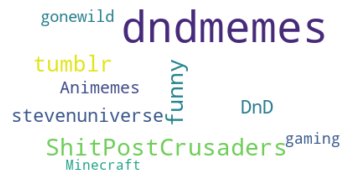

Downvote for 


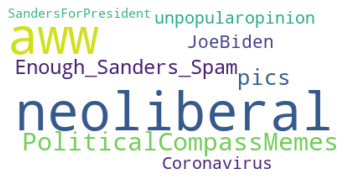

Voter Principle Component 19
Upvote for 


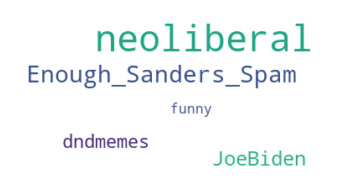

Downvote for 


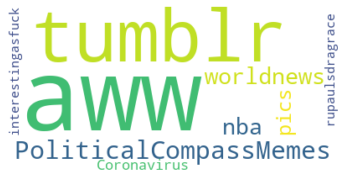

In [14]:
for i in range(0,20):
    Z_sort = np.argsort(Z[:,i])
    print('Voter Principle Component ' + str(i))
    upvote_dict = {}
    downvote_dict = {}
    for j in range(1,11):
        sub_index = Z_sort[-j]
        sub_title = sub1000[sub_index][0][2:]
        sub_weight = Z[sub_index,i]
        upvote_dict[str(sub_title)] = abs(sub_weight)
        #print(str(sub_title) + ': ' + str(sub_weight))
        
    for j in range(10,-1,-1):
        sub_index = Z_sort[j]
        sub_title = sub1000[sub_index][0][2:]
        sub_weight = Z[sub_index,i]
        downvote_dict[str(sub_title)] = abs(sub_weight)
        #print(str(sub_title) + ': ' + str(sub_weight))
    
    print('Upvote for ')
    wordcloud = WordCloud(min_font_size=15,background_color='white')
    wordcloud.generate_from_frequencies(frequencies=upvote_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    print('Downvote for ')
    wordcloud = WordCloud(min_font_size=15,background_color='white')
    wordcloud.generate_from_frequencies(frequencies=downvote_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()